# Install packages and set path

In [1]:
import os
import glob
import pandas as pd
import numpy as np
from scipy import signal
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_validate
import torch
from torch import nn

path = "/home/18rvb/ELEC872/competition/Competition"

In [2]:
# train_meta contains filenames of training data and corresponding labels

train_meta = pd.read_csv(path + '/train_meta.txt', delimiter = ' ', header=None, names=['filename', 'labels'])

In [3]:
train_meta['labels'] = train_meta['labels'].str.replace('[','')
train_meta['labels'] = train_meta['labels'].str.replace(']','')

In [4]:
train_meta['labels'] = train_meta.labels.apply(pd.to_numeric, errors='coerce')

In [5]:
train_meta['labels'] = pd.to_numeric(train_meta.labels, errors='coerce')

In [6]:
# check if balanced dataset

# train_meta.labels.value_counts()

In [7]:
num_list = []
for i in train_meta['filename']:
    temp_list = np.genfromtxt(path + i)
    num_list.append(temp_list)

In [8]:
train_meta['features'] = num_list

In [9]:
# Possible features: rms, mean, max, min, med, skew, kurt, std, iqr, max_energy_freq, mean_freq, median_freq, waveform_length, zero_crossing

means = []

for i in train_meta.features:
    temp_means = []
    for k in i:
        temp_means.append(np.mean(k))
    means.append(temp_means)

In [10]:
train_meta['means'] = means

# Visualizing data after taking mean of 9 channels

In [11]:
import matplotlib.pyplot as plt

x_axis = list(range(1,251))

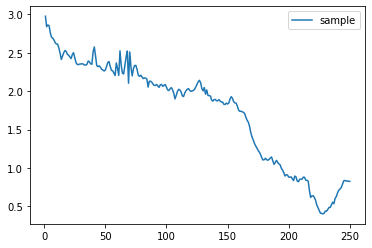

In [12]:
plt.plot(x_axis, train_meta.means[155], label = 'sample')
plt.legend()

# Defining filter (preprocessing, unused)

In [13]:
SAMPLING_FREQUENCY = 1000
BUTTERWORTH_ORDER = 4
BANDPASS_LOW_CUTTING_FREQUENCY = 20
BANDPASS_HIGH_CUTTING_FREQUENCY = 490


def butterworth_filter(data_column):
    nyq = 0.5 * SAMPLING_FREQUENCY
    normal_low_cutoff = BANDPASS_LOW_CUTTING_FREQUENCY / nyq
    normal_high_cutoff = BANDPASS_HIGH_CUTTING_FREQUENCY / nyq

    b, a = signal.butter(BUTTERWORTH_ORDER, [normal_low_cutoff, normal_high_cutoff], 'bandpass', analog=False)
    filtered = signal.filtfilt(b, a, data_column)
    return filtered

In [14]:
filtered_values = []

for val in train_meta.means:
    filtered_values.append(butterworth_filter(val))

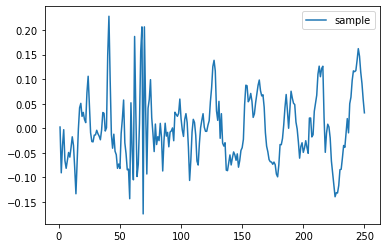

In [15]:
plt.plot(x_axis, butterworth_filter(filtered_values[155]), label = 'sample')
plt.legend()

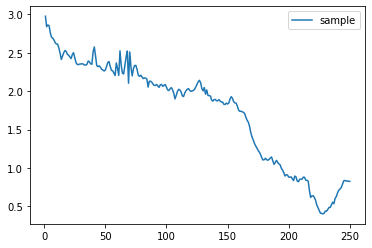

In [16]:
plt.plot(x_axis, train_meta.means[155], label = 'sample')
plt.legend()

# Convert training data to numpy array

In [17]:
list_train_meta_means = []
for i in train_meta.means:  # change to train_meta.means for unfiltered data
    list_train_meta_means.append(i)

In [18]:
np_train_meta = np.array(list_train_meta_means)

In [19]:
np_train_meta.shape

(1350, 250)

# Normalize feature values (Note: Performance drops after doing this with XGBoost)

In [20]:
# normalized

row_sums = np.linalg.norm(np_train_meta, axis=1)
new_matrix = np_train_meta / row_sums[:, np.newaxis]

In [21]:
new_matrix.shape

(1350, 250)

In [22]:
labels = np.array(train_meta.labels)

# Hyperparameter search

In [ ]:
gsc = GridSearchCV(
            estimator=XGBClassifier(),
            param_grid={"n_estimators": [50, 100],
                        "learning_rate": (0.05, 0.10, 0.20, 0.30, 0.40, 0.50),
                        "max_depth": [ 3, 5, 10],
                        "min_child_weight": [ 3, 5, 9],
                        "gamma":[ 0.0, 0.3, 0.5],
                        "colsample_bytree":[ 0.3, 0.5],},
            cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

In [ ]:
gsc.fit(new_matrix, labels)

In [ ]:
print(new_matrix.shape, labels.shape)

# Cross validation metrics

In [23]:
model = XGBClassifier()
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

scoring=('accuracy')
cv_results = cross_validate(model, np_train_meta, labels, cv=kf, scoring=scoring, return_train_score=False)

In [24]:
np.mean(cv_results['test_score'])

0.28444444444444444

In [25]:
torch_train = torch.from_numpy(np_train_meta)
torch_labels = torch.from_numpy(labels)

In [26]:
torch_labels_inc = torch_labels+1

In [ ]:
len(np.unique(np.asarray(torch_labels_inc)))

# LSTM